In [1]:
import pandas as pd
import numpy as np
import pylab as plt

import pysal as ps
import geopandas as gp
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
s = json.load(open(os.getenv('PUI2015')+'/nk1877.json'));
plt.rcParams.update(s)

import shapely.geometry as geom
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
`%matplotlib` prevents importing * from pylab and numpy


##Use the commented link to load data directly from the website 

In [2]:
dat=pd.read_csv("yellow_tripdata_2015-06.csv")
#dat=pd.read_csv("https://storage.googleapis.com/tlc-trip-data/2015/yellow_tripdata_2015-06.csv")
coordinates=np.array([dat['pickup_longitude'],dat['pickup_latitude']]).T

In [3]:
from matplotlib.path import Path
patch = geom.Point(-73.793932,40.598838).buffer(2)
m=Path.circle(center=(-73.793932,40.598838),radius=0.05)
pts=m.contains_points(coordinates)

In [4]:
def counttrue(arr):
    count=0
    for i in arr:
        if(i==True):
            count+=1
    return count
def percentfinder(ttlamt,tip):
    percent=tip/ttlamt
    return percent*100
    

In [5]:
counttrue(pts)

233391

In [6]:
da=dat
ar = pd.DataFrame({'Bool':pts})
db=pd.concat([da,ar],axis=1)
dc= db[db['Bool']==True] 
dd=dc[(dc['fare_amount'] > 0) & (dc['trip_distance']>0)]

In [7]:
dc= db[db['Bool']==True] 
tippercent=dd.apply(lambda row: percentfinder(row['fare_amount'],row['tip_amount']),axis=1)
len(dc)

233391

In [8]:
tip=pd.DataFrame({'tip_percent':tippercent})
dd = pd.concat([dd,tip],axis=1)
len(dd)

228711

In [9]:
dd.shape

(228711, 21)

In [10]:
def color(f):
    area=[]
    for d3 in f:
        if(d3<10):
            area.append('red')
        elif(d3<15):
            area.append('yellow')
        elif(d3<20):
            area.append('green')
        else:
            area.append('green')
    return area

In [11]:
data=dd
data=data.reset_index()

##It is heat map of all the taxi rides going from jfk to everywhere. Looking at map i chose jfk to manhattan downtown as my destination for arrival for analysis.
![heatmap](download.png)

In [12]:

from matplotlib.path import Path
coordinates1=np.array([data['dropoff_longitude'],data['dropoff_latitude']]).T
##destination radius
n=Path.circle(center=(-74.007380,40.714514),radius=0.05)
pts1=n.contains_points(coordinates1)
counttrue(pts1)


78186

In [13]:
ar1 = pd.DataFrame({'Booldrop':pts1})
d1=pd.concat([data,ar1],axis=1)


In [14]:
d2= d1[d1['Booldrop']==True]
d2.shape

(78186, 23)

##further filtering the data to contain only jfk to manhattan locations i was feft with 78186 rows of data.
![heatmap](download2.png)

In [15]:
len(ar1)

228711

In [16]:
d3= d2[(d2['tip_percent']<100) & (d2['trip_distance']<50)]
print d3.shape
tm=(pd.to_datetime(d3.tpep_dropoff_datetime)-pd.to_datetime(d3.tpep_pickup_datetime)).astype('timedelta64[m]')
ar1 = pd.DataFrame({'time':tm})
d3=pd.concat([d3,ar1],axis=1)
d3=d3[d3['time']<200]
d3.head()

(78148, 23)


,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Bool,tip_percent,Booldrop,time
0,88,2,2015-06-02 11:20:37,2015-06-02 12:35:21,2,23.76,-73.791214,40.645409,1,N,...,0,0.5,8.95,11.75,0.3,94.00,True,12.344828,True,74
5,663,2,2015-06-02 11:24:32,2015-06-02 12:39:18,1,17.87,-73.790108,40.644016,2,N,...,0,0.5,11.63,5.33,0.3,69.76,True,22.365385,True,74
6,673,2,2015-06-02 11:24:44,2015-06-02 12:54:54,5,18.08,-73.789848,40.643867,2,N,...,0,0.5,0.00,5.54,0.3,58.34,True,0.000000,True,90
8,887,1,2015-06-02 11:22:35,2015-06-02 12:42:17,1,17.70,-73.782181,40.644665,2,N,...,0,0.5,0.00,5.54,0.3,58.34,True,0.000000,True,79
10,1430,1,2015-06-02 11:21:16,2015-06-02 12:24:44,1,16.70,-73.789932,40.644051,2,N,...,0,0.5,11.65,5.54,0.3,69.99,True,22.403846,True,63


In [17]:
d3.shape

(78004, 24)

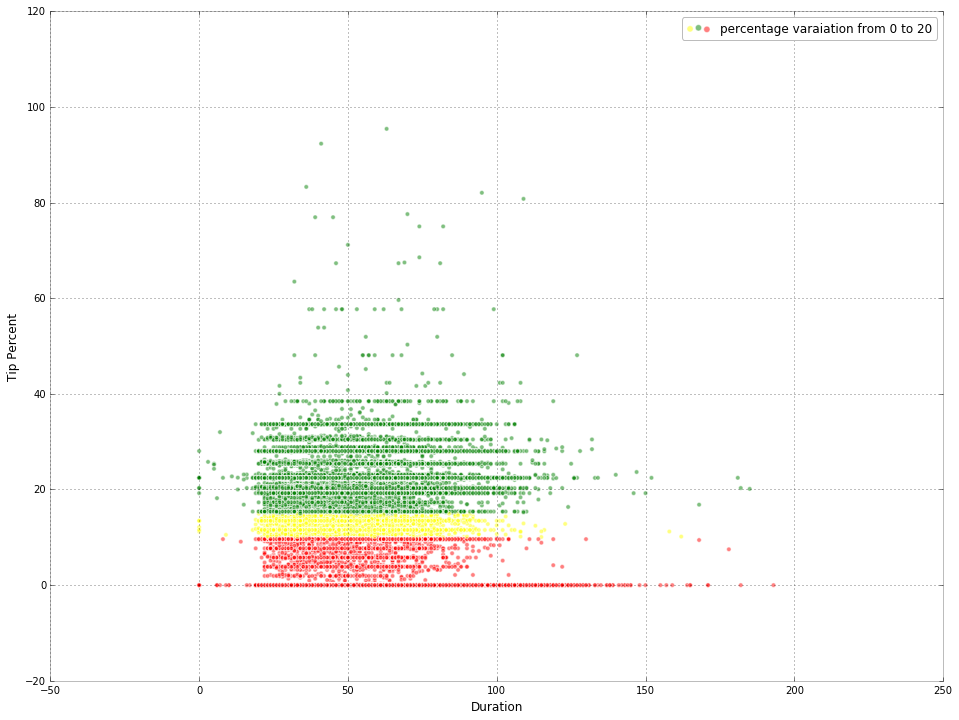

In [18]:
fig=plt.figure(figsize=(16,12))
ax=fig.add_subplot(111)        
plt.scatter(d3['time'],d3['tip_percent'],c=color(d3['tip_percent']),alpha=0.5)
plt.xlabel("Duration")
plt.ylabel("Tip Percent")
lgnd= plt.legend(["percentage varaiation from 0 to 20"])
lgnd.legendHandles[0]._sizes=[40]

###Impanct of duration of distance on tip amout. Example someone covering longer distance to reach manhattan to someone taking shorter distance

                            OLS Regression Results                            
Dep. Variable:            tip_percent   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03600
Date:                Wed, 16 Dec 2015   Prob (F-statistic):              0.850
Time:                        06:37:38   Log-Likelihood:            -2.9703e+05
No. Observations:               78004   AIC:                         5.941e+05
Df Residuals:                   78002   BIC:                         5.941e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            12.7957      0.277     46.267

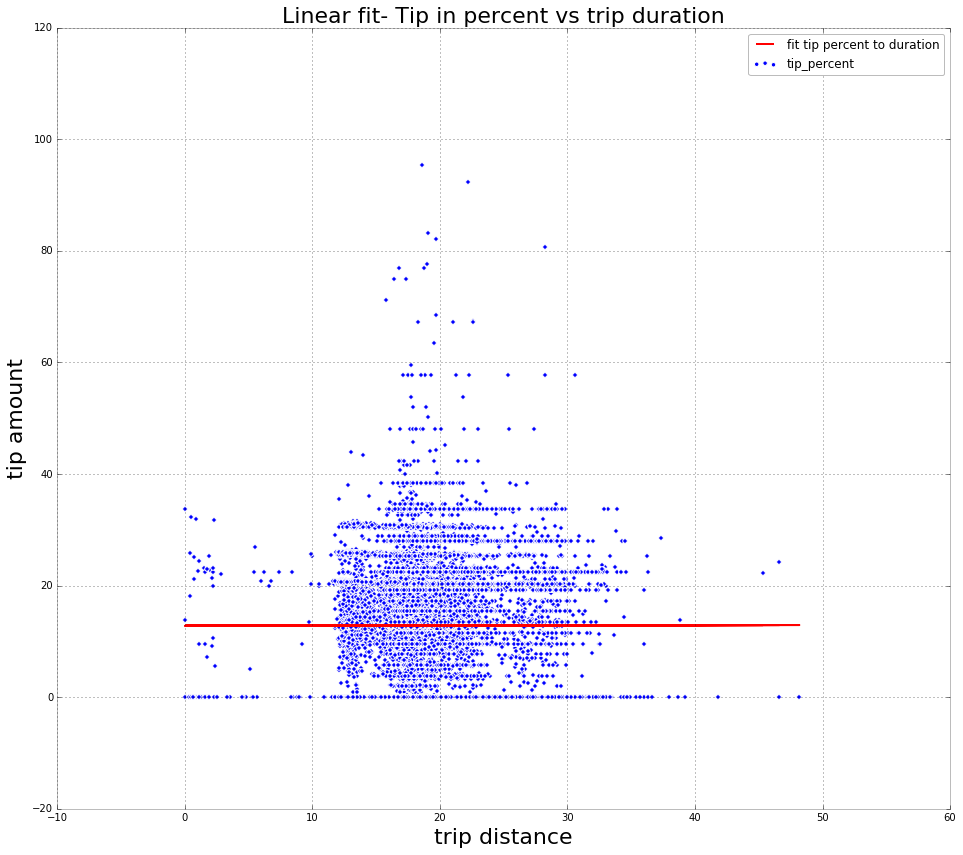

In [19]:
X= sm.add_constant(d3.trip_distance)
fit1= sm.OLS(d3.tip_percent,X, missing='drop').fit()
#p1= fit1.params[1]
p1,p0= fit1.params[1], fit1.params[0]
print fit1.summary()
plt.figure(figsize=(16, 14))
plt.scatter(d3.trip_distance, d3.tip_percent)
plt.xlabel("trip distance", fontsize=22)
plt.ylabel("tip amount", fontsize=22)
plot(d3.trip_distance,fit1.predict(), 'r',label='fit tip percent to duration')
plt.title ("Linear fit- Tip in percent vs trip duration",fontsize=22)
lgnd= plt.legend()
#X= sm.add_constant(d3.tip_percent)
#fit2= sm.OLS(d3.trip_distance,X, missing='drop').fit()
#p1,p0= fit2.params[1], fit2.params[0]
#plot(fit2.predict(),d3.tip_percent, 'b',label='fit duration to tip percent')

                            OLS Regression Results                            
Dep. Variable:             tip_amount   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     633.5
Date:                Wed, 16 Dec 2015   Prob (F-statistic):          3.10e-139
Time:                        06:37:40   Log-Likelihood:            -2.4624e+05
No. Observations:               78004   AIC:                         4.925e+05
Df Residuals:                   78002   BIC:                         4.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          8.2063      0.064    127.684      0.0

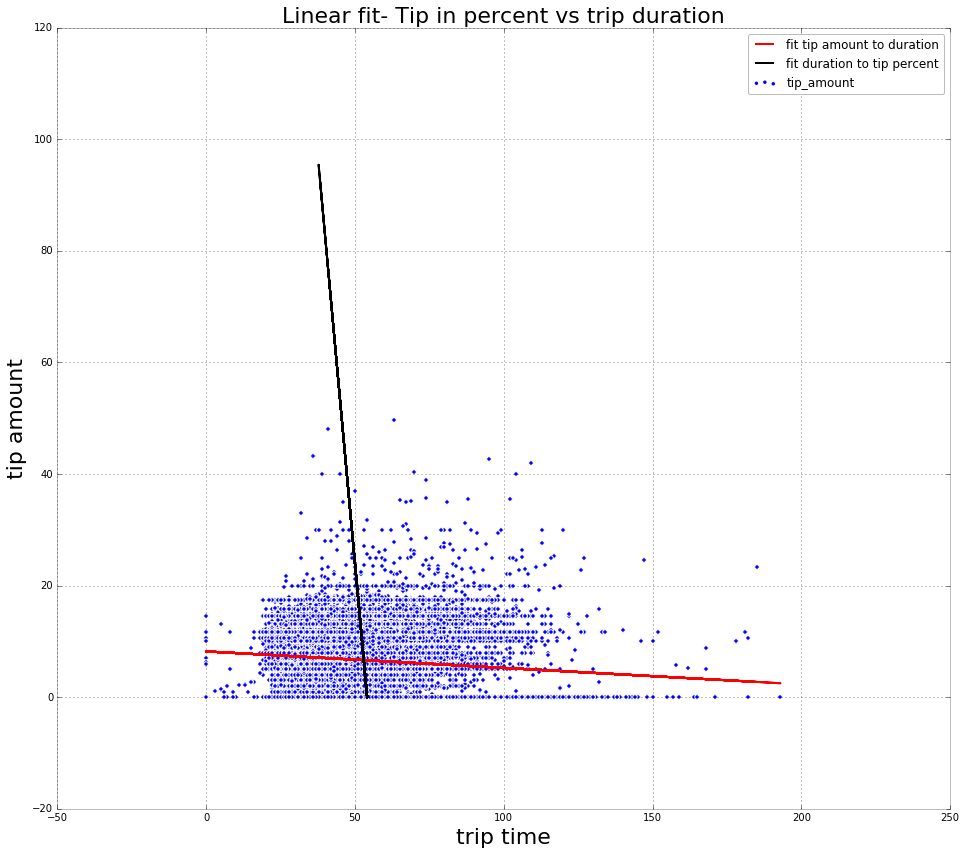

In [20]:
X= sm.add_constant(d3.time)
X1=sm.add_constant(tm)
fit1= sm.OLS(d3.tip_amount,X, missing='drop').fit()
#p1= fit1.params[1]
p1,p0= fit1.params[1], fit1.params[0]
print fit1.summary()
plt.figure(figsize=(16, 14))
plt.scatter(d3.time, d3.tip_amount)
plt.xlabel("trip time", fontsize=22)
plt.ylabel("tip amount", fontsize=22)
plot(d3.time,fit1.predict(), 'r',label='fit tip amount to duration')
plt.title ("Linear fit- Tip in percent vs trip duration",fontsize=22)
X= sm.add_constant(d3.tip_percent)
fit2= sm.OLS(d3.time,X, missing='drop').fit()
p1,p0= fit2.params[1], fit2.params[0]
plot(fit2.predict(),d3.tip_percent, 'k',label='fit duration to tip percent')
lgnd= plt.legend()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.008
Date:                Wed, 16 Dec 2015   Prob (F-statistic):            0.00246
Time:                        06:37:41   Log-Likelihood:            -2.9703e+05
No. Observations:               78004   AIC:                         5.941e+05
Df Residuals:                   78001   BIC:                         5.941e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       15.6744      0.876     17.883   

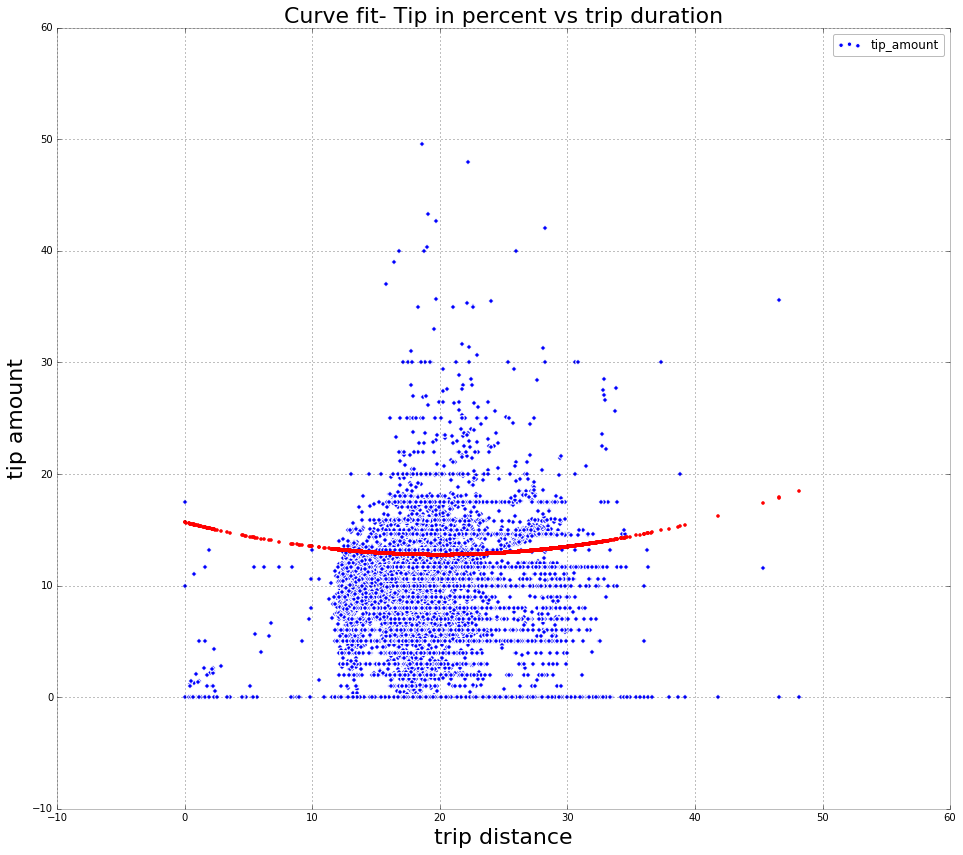

In [21]:
#X= sm.add_constant(d3.trip_distance)
fit1= smf.ols(formula= "y~ x1+ I((x1)) + I((x1)**2)", data={'x1':d3.trip_distance, 'y':d3.tip_percent}).fit()
print fit1.summary()
plt.figure(figsize=(16, 14))
plt.scatter(d3.trip_distance, d3.tip_amount)
plt.xlabel("trip distance", fontsize=22)
plt.ylabel("tip amount", fontsize=22)
plt.title ("Curve fit- Tip in percent vs trip duration",fontsize=22)
plt.plot(d3.trip_distance,fit1.predict(), 'r.')
lgnd= plt.legend()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     458.6
Date:                Wed, 16 Dec 2015   Prob (F-statistic):          9.46e-199
Time:                        06:37:43   Log-Likelihood:            -2.9658e+05
No. Observations:               78004   AIC:                         5.932e+05
Df Residuals:                   78001   BIC:                         5.932e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       16.8640      0.274     61.551   

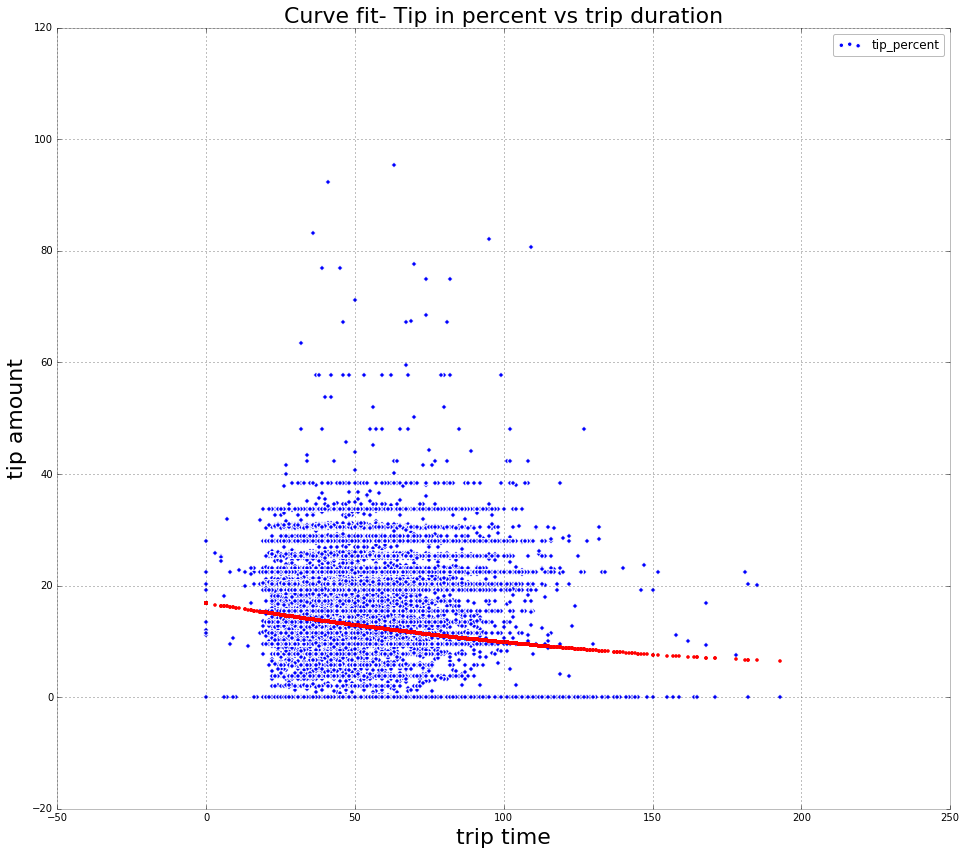

In [22]:
fit1= smf.ols(formula= "y~ x1+ I((x1)) + I((x1)**2)", data={'x1':d3.time, 'y':d3.tip_percent,}).fit()
print fit1.summary()
plt.figure(figsize=(16, 14))
plt.scatter(d3.time, d3.tip_percent)
plt.xlabel("trip time", fontsize=22)
plt.ylabel("tip amount", fontsize=22)
plt.title ("Curve fit- Tip in percent vs trip duration",fontsize=22)
plt.plot(d3.time,fit1.predict(), 'r.')
lgnd= plt.legend()

In [23]:
dk=d3.sort('time')
d3=dk[dk['time']>10]
fit1= smf.ols(formula= "y~ x1+ x2", data={'x1':d3.time,'x2':d3.trip_distance, 'y':d3.tip_percent}).fit()
print fit1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     469.4
Date:                Wed, 16 Dec 2015   Prob (F-statistic):          2.37e-203
Time:                        06:37:45   Log-Likelihood:            -2.9641e+05
No. Observations:               77962   AIC:                         5.928e+05
Df Residuals:                   77959   BIC:                         5.928e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.2813      0.288     53.147      0.0

In [24]:
data1=d3[['time','trip_distance','tip_percent']]

                            OLS Regression Results                            
Dep. Variable:            tip_percent   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     469.4
Date:                Wed, 16 Dec 2015   Prob (F-statistic):          2.37e-203
Time:                        06:37:45   Log-Likelihood:            -2.9641e+05
No. Observations:               77962   AIC:                         5.928e+05
Df Residuals:                   77959   BIC:                         5.928e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        15.2813      0.288     53.147

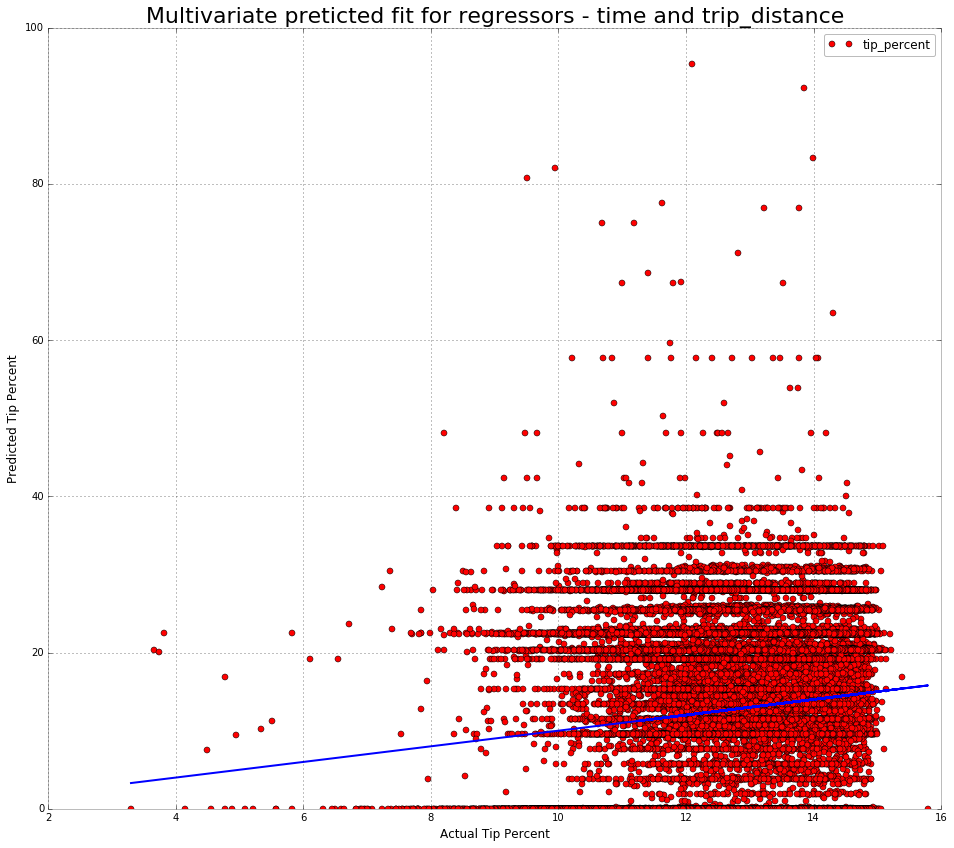

In [25]:
data1= data1[data1['time']<200]
plt.figure(figsize=(16, 14))
ax1 = plt.subplot(111)
lm= smf.ols(formula= "tip_percent~ time+ trip_distance", data=data1).fit()
print(lm.summary())
lmy = lm.predict(data1)
plt.plot(lmy,data1.tip_percent,'or')
plt.plot(lmy,lmy,'-b') 
plt.xlabel('Actual Tip Percent')
plt.ylabel('Predicted Tip Percent')
plt.title ("Multivariate preticted fit for regressors - time and trip_distance",fontsize=22)
lgnd= plt.legend()

In [26]:
data2={'time':np.log(data1.time),'trip_distance':np.log(data1.trip_distance),'tip_percent':np.log(data1.tip_percent)}
data2log = pd.DataFrame(data2)
data2log = data2log[(data2log['tip_percent']!=-inf) & (data2log['trip_distance']!=-inf) & (data2log['time']!=-inf)]

                            OLS Regression Results                            
Dep. Variable:            tip_percent   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.31
Date:                Wed, 16 Dec 2015   Prob (F-statistic):           1.40e-12
Time:                        06:37:46   Log-Likelihood:                -31138.
No. Observations:               49156   AIC:                         6.228e+04
Df Residuals:                   49153   BIC:                         6.231e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.8280      0.044     64.307

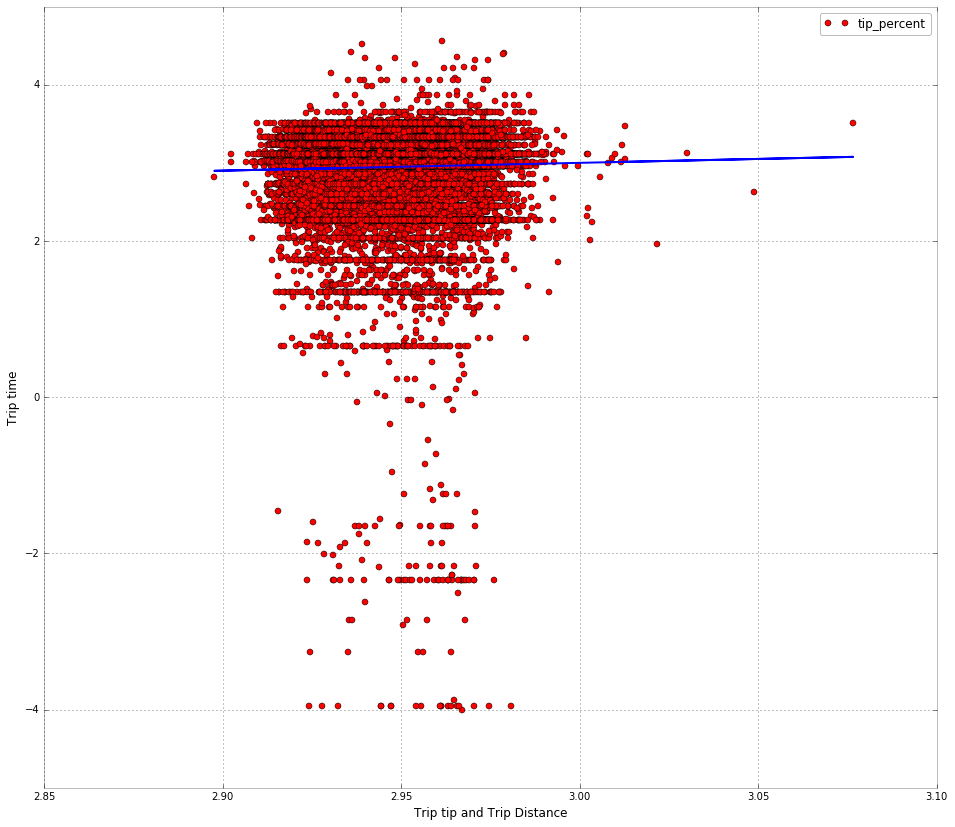

In [27]:
plt.figure(figsize=(16, 14))
ax1 = plt.subplot(111)
lm= smf.ols(formula= "tip_percent~ time+ trip_distance", data=data2log,missing='drop').fit()
print(lm.summary())
lmy = lm.predict(data2log)
plt.plot(lmy,data2log.tip_percent,'or')
plt.plot(lmy,lmy,'-b') 
plt.xlabel('Trip tip and Trip Distance')
plt.ylabel('Trip time')
lgnd= plt.legend()

##Day and Night

In [28]:
d3['tpep_pickup_datetime']= pd.to_datetime(d3.tpep_pickup_datetime)
day = d3[(d3['tpep_pickup_datetime'].dt.hour >6) & (d3['tpep_pickup_datetime'].dt.hour < 18)]
night = d3[(d3['tpep_pickup_datetime'].dt.hour <6) | (d3['tpep_pickup_datetime'].dt.hour > 18)]

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
d3=d3.sort(columns='tpep_pickup_datetime')

In [30]:
tipD=day.groupby(d3['tpep_pickup_datetime'].dt.day).mean()
tipN=night.groupby(d3['tpep_pickup_datetime'].dt.day).mean()

In [31]:
rng = pd.date_range('06/01/2015', '06/30/2015', freq='D')

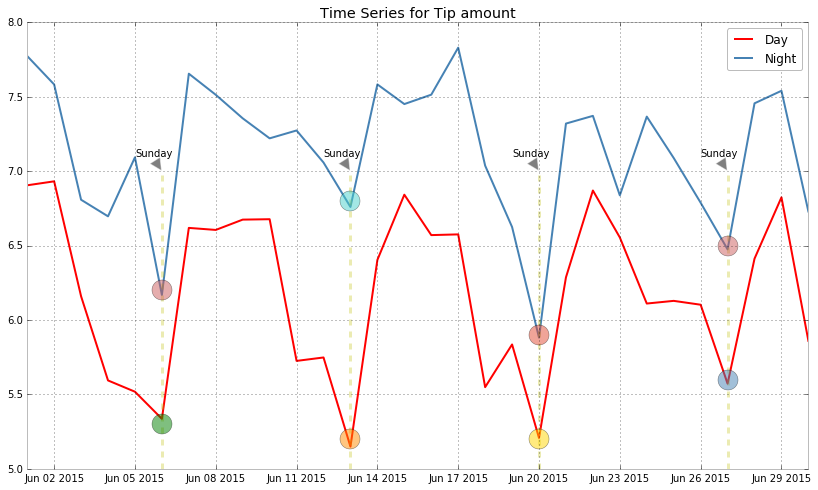

In [32]:
plt.figure(figsize=(14, 8))
plt.plot(rng,tipD['tip_amount'],'r',label='Day')
plt.plot(rng,tipN['tip_amount'],label='Night')
for i in range(4):
    plt.plot((rng[5]+(7)*i, rng[5]+(7)*i), (5, 7), 'y--',lw=3,alpha=0.3)
for i in range(4):
    plt.annotate('Sunday', xy=(rng[5]+(7)*i, 7), xytext=(rng[4]+(7)*i, 7.1),arrowprops=dict(facecolor='black', shrink=0.05,alpha=0.5))
plt.plot('2015-06-06', 6.2,markersize=20,marker='o',alpha=0.5)
plt.plot('2015-06-06', 5.3,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+7, 5.2,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+7, 6.8,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+14, 5.2,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+14, 5.9,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+21, 5.6,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+21, 6.5,markersize=20,marker='o',alpha=0.5)
plt.title("Time Series for Tip amount")
plt.legend()

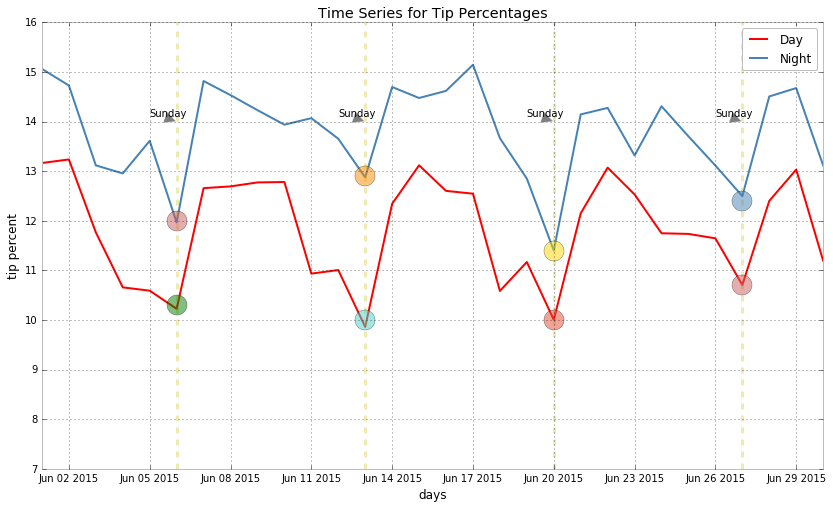

In [33]:
plt.figure(figsize=(14, 8))
plt.plot(rng,tipD['tip_percent'],'r',label='Day')
plt.plot(rng,tipN['tip_percent'],label='Night')
for i in range(4):
    plt.plot((rng[5]+(7)*i, rng[5]+(7)*i), (7, 16), 'y--',lw=3,alpha=0.3)
for i in range(4):
    plt.annotate('Sunday', xy=(rng[5]+(7)*i, 14), xytext=(rng[4]+(7)*i, 14.1),arrowprops=dict(facecolor='black', shrink=0.05,alpha=0.5))
plt.plot('2015-06-06', 12,markersize=20,marker='o',alpha=0.5)
plt.plot('2015-06-06', 10.3,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+7,12.9,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+7,10,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+14, 11.4,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+14, 10,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+21, 12.4,markersize=20,marker='o',alpha=0.5)
plt.plot(rng[5]+21, 10.7,markersize=20,marker='o',alpha=0.5)
plt.title("Time Series for Tip Percentages")
plt.xlabel('days')
plt.ylabel('tip percent')
plt.legend()

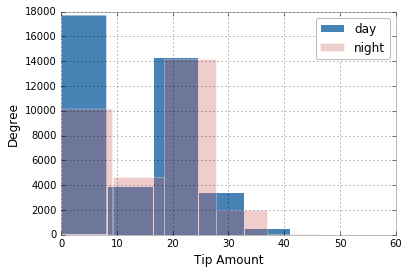

In [34]:
day['tip_percent'].plot(kind='hist',label='day')
night['tip_percent'].plot(kind='hist',alpha=0.3,label='night',xlim=(0,60))
plt.xlabel("Tip Amount")
lgnd= plt.legend()

                            OLS Regression Results                            
Dep. Variable:            tip_percent   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     89.82
Date:                Wed, 16 Dec 2015   Prob (F-statistic):           1.20e-39
Time:                        06:37:50   Log-Likelihood:            -1.5361e+05
No. Observations:               40062   AIC:                         3.072e+05
Df Residuals:                   40059   BIC:                         3.072e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        13.7375      0.411     33.422

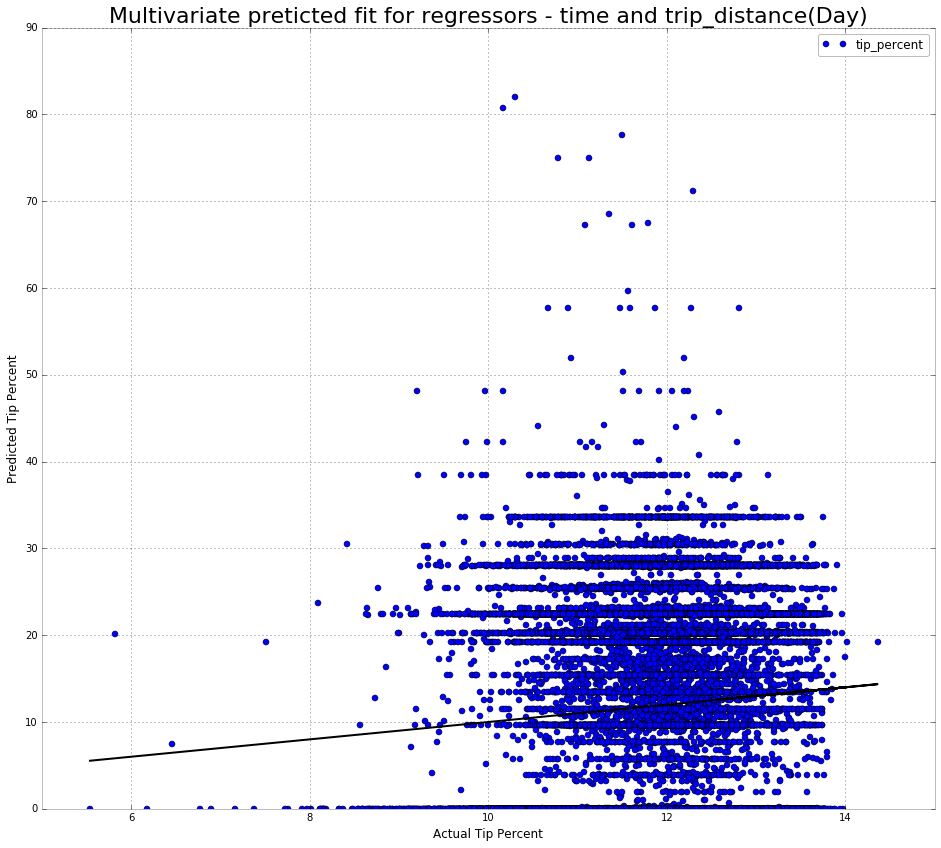

In [35]:
plt.figure(figsize=(16, 14))
ax1 = plt.subplot(111)
lm= smf.ols(formula= "tip_percent~ time+ trip_distance", data=day).fit()
print(lm.summary())
lmy = lm.predict(day)
plt.plot(lmy,day.tip_percent,'ob')
plt.plot(lmy,lmy,'-k') 
plt.xlabel('Actual Tip Percent')
plt.ylabel('Predicted Tip Percent')
plt.title ("Multivariate preticted fit for regressors - time and trip_distance(Day)",fontsize=22)
lgnd= plt.legend()

                            OLS Regression Results                            
Dep. Variable:            tip_percent   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     89.78
Date:                Wed, 16 Dec 2015   Prob (F-statistic):           1.33e-39
Time:                        06:37:51   Log-Likelihood:            -1.1676e+05
No. Observations:               31070   AIC:                         2.335e+05
Df Residuals:                   31067   BIC:                         2.336e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        16.0939      0.470     34.231

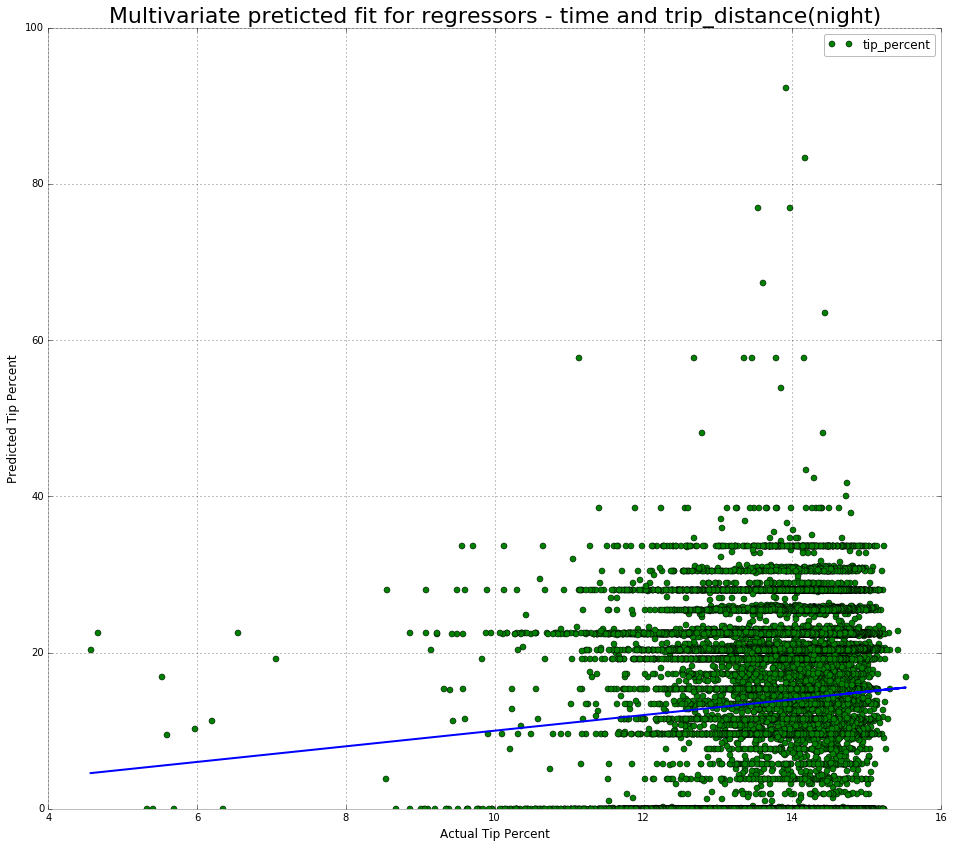

In [36]:
plt.figure(figsize=(16, 14))
ax1 = plt.subplot(111)
lm= smf.ols(formula= "tip_percent~ time+ trip_distance", data=night).fit()
print(lm.summary())
lmy = lm.predict(night)
plt.plot(lmy,night.tip_percent,'og')
plt.plot(lmy,lmy,'-b') 
plt.xlabel('Actual Tip Percent')
plt.ylabel('Predicted Tip Percent')
lgnd= plt.legend()
plt.title ("Multivariate preticted fit for regressors - time and trip_distance(night)",fontsize=22)

             tip_percent  tip_amount
tip_percent     1.000000    0.991227
tip_amount      0.991227    1.000000


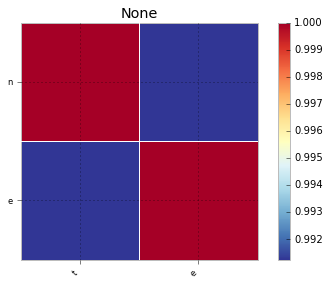

In [37]:
co=d3[['tip_percent','tip_amount']]
mat=co.corr(method='pearson')
print mat
sm.graphics.plot_corr(mat, xnames='tesjt',ynames='None', title='None')
plt.show()